In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
file='final_results_2'
file2='figs'

In [2]:
def survivors(fractions, num_strains, target_reseeds, trlnumber):
    #Calculates the number of survivors at the final dilution from fractions data
    #num_strains is an integer

    survivors_ = np.zeros(trlnumber)
    
    for ii in range(trlnumber):
        survivors_[ii]=np.count_nonzero(fractions[ii,target_reseeds,:])/num_strains

    return survivors_

In [3]:
def fractions_cheaters(fractions, target_reseeds, trlnumber):
    #Calculates the fractions of a QS strains and its cheaters

    frac_QS = np.zeros(trlnumber)
    frac_ch = np.zeros(trlnumber)
    
    for ii in range(trlnumber):
        tot_frac = fractions[ii,target_reseeds,0] + fractions[ii,target_reseeds,1]
        if tot_frac != 0:
            frac_QS[ii] = fractions[ii,target_reseeds,0]/tot_frac
            frac_ch[ii] = fractions[ii,target_reseeds,1]/tot_frac
        else:
            frac_QS[ii] = 0
            frac_ch[ii] = 0
        

    return frac_QS, frac_ch

In [4]:
def shannon(fractions, num_strains, target_reseeds, trlnumber):
    #Calculates Shannon Index at the final dilution from fractions data
    #num_strains is an integer

    shannon_ = np.zeros(trlnumber)
    
    for ii in range(trlnumber):
        SE=0
        for kk in range(num_strains):
            if fractions[ii,target_reseeds,kk] != 0:
                SE=SE-(fractions[ii,target_reseeds,kk]*np.log(fractions[ii,target_reseeds,kk]))
        shannon_[ii]=np.exp(SE)/num_strains

    return shannon_

In [5]:
def QSsurvivors(fractions, num_strains, qs_strains, target_reseeds, trlnumber):
    #Calculates the number of surviving QS strains at the final dilution from fractions data
    #num_strains is an integer

    QSsurvivors_ = np.zeros(trlnumber)
    
    for ii in range(trlnumber):
        num_qs_strains = np.count_nonzero(qs_strains[ii])
        QSsurvivors_[ii]=np.count_nonzero(fractions[ii][target_reseeds][qs_strains[ii]==1])/num_qs_strains

    return QSsurvivors_

In [6]:
def NQSsurvivors(fractions, num_strains, qs_strains, target_reseeds, trlnumber):
    #Calculates the number of surviving NQS strains at the final dilution from fractions data
    #num_strains is an integer

    NQSsurvivors_ = np.zeros(trlnumber)
    
    for ii in range(trlnumber):
        num_qs_strains = np.count_nonzero(qs_strains[ii])
        num_nqs = num_strains-num_qs_strains
        NQSsurvivors_[ii] = np.count_nonzero(fractions[ii][target_reseeds][qs_strains[ii]==0])/num_nqs

    return NQSsurvivors_

In [7]:
def percentage_diff(data_ref, data):

    #Calculates percentage difference of the means of two data sets taking one as reference
    #Returns the confidence intervals for the percentage difference

    factor=100/np.average(data_ref)

    n1, n2 = 5000, 5000
    s1, s2 = np.var(data, ddof=1), np.var(data_ref, ddof=1)

    # Pooled standard deviation
    pooled_var = ((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 - 2)
    pooled_std = np.sqrt(pooled_var)

    # Standard error using pooled std
    se = pooled_std * np.sqrt(1/n1 + 1/n2)

    x=stats.ttest_ind(data,data_ref)

    t_stat=x[0]

    p_value = x[1]

    PD_QI=t_stat*se*factor

    cb = factor*(x.confidence_interval(confidence_level=0.95)[0]) #Confidence intervale lowest value
    cu = factor*(x.confidence_interval(confidence_level=0.95)[1]) #Confidence intervale upper value

    return PD_QI, p_value, cb, cu

In [8]:
def QSImpact(names, num_strains, target_reseeds, trlnumber):

    #Returns QS impact for each variable value. Reads data using the files' names.
    #num_strains is an array (each value for each file if necessary)

    number_points = len(names)
    
    QS_imp = np.zeros((4,number_points))  #QS Impact value for each value of the variable 
    p_val = np.zeros((4,number_points))   #p-values for each value fo the variable
    CI = np.zeros((4,number_points,2))    #Confidence intervals for each QS Impact avlue
    
    for kk in range(number_points):
        file_2=names[kk]
        fractions=np.load(file+'/fractions_'+file_2+'.npy')
        fractions_IQS=np.load(file+'/fractionsNQS_'+file_2+'.npy')
        qs_s=np.load(file+'/qs_'+file_2+'.npy')

        surv = survivors(fractions, num_strains[kk], target_reseeds, trlnumber)
        surv_IQS = survivors(fractions_IQS, num_strains[kk], target_reseeds, trlnumber)
        
        PD_QI, p_value, cb, cu = percentage_diff(surv_IQS, surv)

        QS_imp[0,kk] = PD_QI
        p_val[0,kk] = p_value
        CI[0,kk,0]=cb
        CI[0,kk,1]=cu

        shan = shannon(fractions, num_strains[kk], target_reseeds, trlnumber)
        shan_IQS = shannon(fractions_IQS, num_strains[kk], target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(shan_IQS, shan)

        QS_imp[1,kk] = PD_QI
        p_val[1,kk] = p_value
        CI[1,kk,0]=cb
        CI[1,kk,1]=cu

        QSsurv = QSsurvivors(fractions, num_strains[kk], qs_s, target_reseeds, trlnumber)
        QSsurv_IQS = QSsurvivors(fractions_IQS, num_strains[kk], qs_s, target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(QSsurv_IQS, QSsurv)

        QS_imp[2,kk] = PD_QI
        p_val[2,kk] = p_value
        CI[2,kk,0]=cb
        CI[2,kk,1]=cu

        NQSsurv = NQSsurvivors(fractions, num_strains[kk], qs_s, target_reseeds, trlnumber)
        NQSsurv_IQS = NQSsurvivors(fractions_IQS, num_strains[kk], qs_s, target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(NQSsurv_IQS, NQSsurv)

        QS_imp[3,kk] = PD_QI
        p_val[3,kk] = p_value
        CI[3,kk,0]=cb
        CI[3,kk,1]=cu
    
    return QS_imp, p_val, CI

## Figure 2 Adding QS to LV equations increases the number of surviving strains compared with LV system without QS.

### Panel 2a. Adding QS to LV equations increases the number of survivors but shannon index is not affected

In [21]:
#This cell prepars data to use in DABEST script in MatLab

target_reseeds = 200
trlnumber = 5000
num_strains = 15

#Load distributions for S and D in the QSLV and LV dynamical systems
file_2='beta_1e9_15s_st_1e9'
fractions=np.load(file+'/fractions_'+file_2+'.npy')
fractions_IQS=np.load(file+'/fractionsNQS_'+file_2+'.npy')
qs_s=np.load(file+'/qs_'+file_2+'.npy')

surv=survivors(fractions, num_strains, target_reseeds, trlnumber)
surv_IQS=survivors(fractions_IQS, num_strains, target_reseeds, trlnumber)

shan = shannon(fractions, num_strains, target_reseeds, trlnumber)
shan_IQS = shannon(fractions_IQS, num_strains, target_reseeds, trlnumber)

#Preparing exportation. Concatenate distributions in the same collumn
DABEST_c0 = np.concatenate((surv_IQS,surv))
DABEST_c0 = np.concatenate((DABEST_c0,shan_IQS))
DABEST_c0 = np.concatenate((DABEST_c0,shan))

#Prepare a second collumn with the labels of the data
DABEST_l1 = np.full(len(surv), 'LV-S')
DABEST_l2 = np.full(len(surv), 'LVQS-S')
DABEST_l3 = np.full(len(surv), 'LV-D')
DABEST_l4 = np.full(len(surv), 'LVQS-D')

DABEST_c1 = np.concatenate((DABEST_l1,DABEST_l2))
DABEST_c1 = np.concatenate((DABEST_c1,DABEST_l3))
DABEST_c1 = np.concatenate((DABEST_c1,DABEST_l4))

#Prepare pandas dataframe for exportation
df = pd.DataFrame({'Identifiers' : DABEST_c1, 'Values' : DABEST_c0})

#Export
#df.to_csv(file+'/figs/fig_statistical_vis/figure2a_data.csv', index=False)

### Panel 2b. Number of survivors and Shannon index increase with the number of QS strains.

In [24]:
target_reseeds = 200
trlnumber=5000

name=np.array(['p10', 'p15', 'p20', 'p25', 'p35', 'p40', 'p50', 'p502', 'p60', 'p65', 'p75', 'p80', 'p85', 'p90', 'p100'])
names=np.full(len(name), '',dtype=object)
num_strains = np.full(len(name),15)

for kk in range(len(name)):
    if kk!=2:
        names[kk]='beta_1e9_15s_st_1e9_QS'+name[kk]
    else:
        names[kk]='beta_1e9_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

x_var = np.arange(1,15+1)*100/15
yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

/var/folders/s3/sfwb9bxx1d1_8lw_f0b9k8s80000gn/T/ipykernel_31736/871928401.py:10: RuntimeWarning: invalid value encountered in scalar divide
  NQSsurvivors_[ii] = np.count_nonzero(fractions[ii][target_reseeds][qs_strains[ii]==0])/num_nqs


(array([0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3]),
 array([0, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4]))

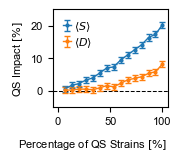

In [25]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, yy, yerr=yy_err, capsize=2.5, marker='.', markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
p101=axs.errorbar(x_var, yy2, yerr=yy2_err, capsize=2.5, marker='.', markersize=4, linewidth=1, color='tab:orange', label=r'$\langle D \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylabel(r'QS Impact $[\%]$', size=8)

axs.set_ylim([-5,25])
axs.set_xlim([-5,105])

axs.legend(fontsize=8, labelspacing=0.2, frameon=False, handlelength=0.75, handletextpad=0.3)

axs.set_xlabel(r'Percentage of QS Strains $[\%]$', size=8)
axs.xaxis.set_label_coords(0.35, -0.3)

plt.savefig(file+'/'+file2+'/fig2b.pdf',bbox_inches='tight',format="pdf", dpi=900)

plt.show()

### Panel 2c. Number of survivors increases with thu number of interactions modified by QS, Shannon index is not affected

In [39]:
target_reseeds = 200
trlnumber = 5000
num_strains = np.full(len(name),15)

name=np.array(['a10', 'a20', 'a30', 'a40', 'a50', 'a60', 'a70', 'a80', 'a90', 'a100'])
names=np.full(len(name), '',dtype=object)
num_strains = np.full(15,len(name))

for kk in range(len(name)):
    if kk!=2:
        names[kk]='beta_1e9_15s_st_1e9_qs'+name[kk]
    else:
        names[kk]='beta_1e9_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

x_var2 = np.arange(10,100+10,10)
yy_2 = QSIM[0]
yy2_2 = QSIM[1]

yy_2_err = np.abs(np.vstack((yy_2,yy_2))-np.transpose(CI[0]))
yy2_2_err = np.abs(np.vstack((yy2_2,yy2_2))-np.transpose(CI[1]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3]),
 array([0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4]))

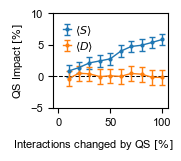

In [40]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p011=axs.errorbar(x_var2, yy_2, yerr=yy_2_err, capsize=2.5, marker='.', markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
p111=axs.errorbar(x_var2, yy2_2, yerr=yy2_2_err, capsize=2.5, marker='.', markersize=4, linewidth=1, color='tab:orange', label=r'$\langle D \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylabel(r'QS Impact $[\%]$', size=8)

axs.set_ylim([-5,10])
axs.set_xlim([-5,105])

axs.set_xlabel(r'Interactions changed by QS $[\%]$', size=8)
axs.xaxis.set_label_coords(0.35, -0.3)

axs.legend(fontsize=8, labelspacing=0.2, frameon=False, handlelength=0.75, handletextpad=0.3)

plt.savefig(file+'/'+file2+'/fig2c.pdf',bbox_inches='tight', format="pdf", dpi=900)

plt.show()

### Panel 2d. Adding QS to LV equations increases the number of QS survivors but non-QS survivors is not affected

In [57]:
#This cell prepers data to use in DABEST script in MatLab
target_reseeds = 200
trlnumber = 5000
num_strains = 15
num_nqs = 12
num_qs = 3

#Load distributions for S and D in the QSLV and LV dynamical systems
file_2='beta_1e9_15s_st_1e9'
fractions=np.load(file+'/fractions_'+file_2+'.npy')
fractions_IQS=np.load(file+'/fractionsNQS_'+file_2+'.npy')
qs_s=np.load(file+'/qs_'+file_2+'.npy')

surv=survivors(fractions, num_strains, target_reseeds, trlnumber)
surv_IQS=survivors(fractions_IQS, num_strains, target_reseeds, trlnumber)

QSsurv=QSsurvivors(fractions, num_strains, qs_s, target_reseeds, trlnumber)
QSsurv_IQS=QSsurvivors(fractions_IQS, num_strains, qs_s, target_reseeds, trlnumber)

#Direct caculation of NQSsurv with NQSsurvivors function leads to an error in dabest
#But, using the theoretical calculation produces data that dabest can read
#The difference between both sets of data is negligible 

NQSsurv = surv*(num_strains/num_nqs) - QSsurv*(num_qs/num_nqs)
NQSsurv_IQS = surv_IQS*(num_strains/num_nqs) - QSsurv_IQS*(num_qs/num_nqs)

#Lines for direct calculation of NQSsurv
#NQSsurv = NQSsurvivors(fractions, num_strains, qs_s, target_reseeds, trlnumber)
#NQSsurv_IQS = NQSsurvivors(fractions_IQS, num_strains, qs_s, target_reseeds, trlnumber)

#Preparing exportation. Concatenate distributions in the same collumn
DABEST_c0 = np.concatenate((QSsurv_IQS,QSsurv))
DABEST_c0 = np.concatenate((DABEST_c0,NQSsurv_IQS))
DABEST_c0 = np.concatenate((DABEST_c0,NQSsurv))

#Prepare a second collumn with the labels of the data
DABEST_l1 = np.full(len(QSsurv), 'LV-S')
DABEST_l2 = np.full(len(QSsurv), 'LVQS-S')
DABEST_l3 = np.full(len(QSsurv), 'LV-D')
DABEST_l4 = np.full(len(QSsurv), 'LVQS-D')

DABEST_c1 = np.concatenate((DABEST_l1,DABEST_l2))
DABEST_c1 = np.concatenate((DABEST_c1,DABEST_l3))
DABEST_c1 = np.concatenate((DABEST_c1,DABEST_l4))

#Prepare pandas dataframe for exportation
df = pd.DataFrame({'Identifiers' : DABEST_c1, 'Values' : DABEST_c0})

#Export
df.to_csv(file+'/figs/fig_statistical_vis/figure3a_data.csv', index=False)

### Panel 2e. The percentage of QS strains increases the benefit for QS strains.

In [41]:
target_reseeds = 200
trlnumber=5000

name=np.array(['p10', 'p15', 'p20', 'p25', 'p35', 'p40', 'p50', 'p502', 'p60', 'p65', 'p75', 'p80', 'p85', 'p90', 'p100'])
names=np.full(len(name), '',dtype=object)
for kk in range(len(name)):
    if kk!=2:
        names[kk]='beta_1e9_15s_st_1e9_QS'+name[kk]
    else:
        names[kk]='beta_1e9_15s_st_1e9'

num_strains = np.full(len(name), 15)

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

x_var = np.arange(1,15+1)*100/15
yy = np.transpose(QSIM[2])
yy2 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[2]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

/var/folders/s3/sfwb9bxx1d1_8lw_f0b9k8s80000gn/T/ipykernel_31736/871928401.py:10: RuntimeWarning: invalid value encountered in scalar divide
  NQSsurvivors_[ii] = np.count_nonzero(fractions[ii][target_reseeds][qs_strains[ii]==0])/num_nqs


(array([0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3]),
 array([0, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4]))

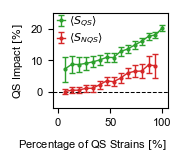

In [42]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p011=axs.errorbar(x_var, yy, yerr=yy_err, capsize=2.5, marker='.', markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var, yy2, yerr=yy2_err, capsize=2.5, marker='.', markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylabel(r'QS Impact $[\%]$', size=8)

axs.tick_params(axis='both', which='both', labelsize=8)

axs.set_ylim([-5,25])
axs.set_xlim([-5,105])

axs.legend(fontsize=8, loc=(0, 0.6), labelspacing=0.2, frameon=False, handlelength=0.75, handletextpad=0.3)

axs.set_xlabel(r'Percentage of QS Strains $[\%]$', size=8)
axs.xaxis.set_label_coords(0.35, -0.3)

plt.savefig(file+'/'+file2+'/fig2e.pdf', format="pdf", bbox_inches='tight', dpi=900)

plt.show()

### Panel 2f. The number of QS survivors increases with the number of interactions modified by QS, The non-QS survivors number is not affected

In [43]:
target_reseeds = 200
trlnumber = 5000

name=np.array(['a10', 'a20', 'a30', 'a40', 'a50', 'a60', 'a70', 'a80', 'a90', 'a100'])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    if kk!=2:
        names[kk]='beta_1e9_15s_st_1e9_qs'+name[kk]
    else:
        names[kk]='beta_1e9_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

x_var2 = np.arange(10,100+10,10)
yy_2 = QSIM[2]
yy2_2 = QSIM[3]

yy_2_err = np.abs(np.vstack((yy_2,yy_2))-np.transpose(CI[2]))
yy2_2_err = np.abs(np.vstack((yy2_2,yy2_2))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3]),
 array([0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4]))

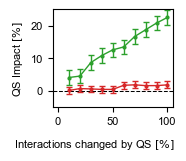

In [44]:
fig, axs = plt.subplots(1, figsize=(1.75, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p011=axs.errorbar(x_var2, yy_2, yerr=yy_2_err, capsize=2.5, marker='.', markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var2, yy2_2, yerr=yy2_2_err, capsize=2.5, marker='.', markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylabel(r'QS Impact $[\%]$', size=8)

axs.tick_params(axis='both', which='both', labelsize=8)

axs.set_ylim([-5,25])
axs.set_xlim([-5,105])

axs.set_xlabel(r'Interactions changed by QS $[\%]$', size=8)
axs.xaxis.set_label_coords(0.35, -0.3)

plt.savefig(file+'/'+file2+'/fig2f.pdf', format="pdf", bbox_inches='tight', dpi=900)

plt.show()

## Figure 7. If there are enough QS strains the cost stops beign dentrimental.

In [12]:
target_reseeds = 200
trlnumber=5000

name=np.linspace(1,15,15)
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    names[kk]='beta_1e9_15s_st_1e9_cost_3_QS_'+str(int(kk+1))

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

variable='cost_3_QS'
table=np.load(file+'/'+variable+'_var_'+str(0)+'.npy')
for num_file in range(len(name)-1):
    tab=np.load(file+'/'+variable+'_var_'+str(num_file+1)+'.npy')
    table=np.hstack((table,tab))
x_var=table[0,:]*(100/15)

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

/var/folders/s3/sfwb9bxx1d1_8lw_f0b9k8s80000gn/T/ipykernel_16485/871928401.py:10: RuntimeWarning: invalid value encountered in scalar divide
  NQSsurvivors_[ii] = np.count_nonzero(fractions[ii][target_reseeds][qs_strains[ii]==0])/num_nqs


(array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3]),
 array([0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 0]))

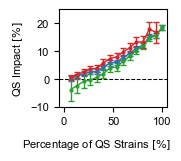

In [13]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, yy, marker='.', yerr=yy_err, capsize=2.5, markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
#p100=axs.errorbar(x_var, yy2, marker='.', yerr=yy2_err, capsize=2.5, markersize=4, linewidth=1, color='tab:orange', label=r'$\langle D \rangle$')
p011=axs.errorbar(x_var, yy1, marker='.', yerr=yy1_err, capsize=2.5, markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var, yy12, marker='.', yerr=yy12_err, capsize=2.5, markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_xlim([-5,105])

axs.set_ylim([-10,25])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_xlabel(r'Percentage of QS Strains $[\%]$', size=8)
axs.xaxis.set_label_coords(0.35, -0.3)

plt.savefig(file+'/'+file2+'/figS3.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

## Figure 3A. Cost is still beneficial if it is small.

In [39]:
target_reseeds = 200
trlnumber=5000

name=np.linspace(0,10,5)
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    names[kk]='beta_1e9_15s_st_1e9_cost'+str(int(name[kk]*10))+'_3'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

variable='cost_3'
table=np.load(file+'/'+variable+'_var_'+str(0)+'.npy')
for num_file in range(len(name)-1):
    tab=np.load(file+'/'+variable+'_var_'+str(num_file+1)+'.npy')
    table=np.hstack((table,tab))
x_var=table[0,:]

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([0, 0, 1, 1, 1, 2, 3]), array([3, 4, 0, 1, 2, 1, 0]))

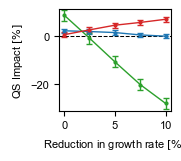

In [51]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, yy, marker='.', yerr=yy_err, capsize=2.5, markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
p011=axs.errorbar(x_var, yy1, marker='.', yerr=yy1_err, capsize=2.5, markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var, yy12, marker='.', yerr=yy12_err, capsize=2.5, markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-31,11])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_xlabel(r'Reduction in growth rate $[\%]$', size=8)

plt.savefig(file+'/'+file2+'/fig2h.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

## Figure 3C. Cheating on QS.

In [9]:
target_reseeds = 200
trlnumber = 5000
num_strains = 15
x_var = np.array([1,5,10,15,20])

prob_QS = np.zeros(len(x_var))
prob_NQS = np.zeros(len(x_var))

ii=0
for ll in x_var:
    
    file_2 = 'cheating_90-10_20perc_25c_size_2_'+str(ll)
    fractions_NQS=np.load(file+'/fractions_NQS_'+file_2+'.npy')
    fractions=np.load(file+'/fractions_'+file_2+'.npy')

    frac_QS_NQS, frac_cheaters_NQS = fractions_cheaters(fractions_NQS, target_reseeds, trlnumber)
    frac_QS, frac_cheaters = fractions_cheaters(fractions, target_reseeds, trlnumber)

    prob_QS[ii] = np.count_nonzero(frac_QS)/trlnumber
    prob_NQS[ii] = np.count_nonzero(frac_QS_NQS)/trlnumber

    ii=ii+1

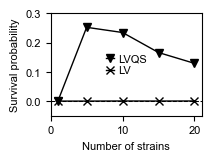

In [11]:
fig, axs = plt.subplots(1, figsize=(2, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.plot(x_var, prob_QS, marker='v', color='black', linewidth=1, label='LVQS')
axs.plot(x_var, prob_NQS, marker='x', color='black', linewidth=1, label='LV')

axs.set_xlim([0,21])
axs.set_ylim([-0.05,0.3])
axs.tick_params(axis='both', which='both', labelsize=8)
axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.set_xlabel(r'Number of strains', size=8)
axs.set_ylabel(r'Survival probability', size=8)
axs.legend(fontsize=8,labelspacing=0.2, frameon=False, handlelength=0.75, handletextpad=0.3)

plt.savefig(file+'/'+file2+'/fig3c.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

## Figure 4A. Antifragility

### Panel 3a. Average number of survivors convex response to the number of QS strains and the number of interactions modified by QS.

In [17]:
target_reseeds = 200
trlnumber=5000

name=np.array(['p10', 'p15', 'p20', 'p25', 'p35', 'p40', 'p50', 'p502', 'p60', 'p65', 'p75', 'p80', 'p85', 'p90', 'p100'])
names=np.full(len(name), '',dtype=object)
num_strains = 15

surv_a = np.zeros(len(name))
yy_err = np.zeros(len(name))

for kk in range(len(name)):
    if kk!=2:
        names[kk]='beta_1e9_15s_st_1e9_QS'+name[kk]
    else:
        names[kk]='beta_1e9_15s_st_1e9'

    file_2=names[kk]
    fractions=np.load(file+'/fractions_'+names[kk]+'.npy')

    surv_a[kk]=np.average(survivors(fractions, num_strains, target_reseeds, trlnumber))
    yy_err[kk]=np.std(survivors(fractions, num_strains, target_reseeds, trlnumber))


name = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
names=np.full(len(name), '',dtype=object)
num_strains = 15

surv2_a = np.zeros(len(name))
yy2_err = np.zeros(len(name))

for kk in range(len(name)):
    names[kk]='beta_1e9_15s_st_1e9_a70_'+str(name[kk])

    file_2=names[kk]
    fractions=np.load(file+'/fractions_'+names[kk]+'.npy')

    surv2_a[kk]=np.average(survivors(fractions, num_strains, target_reseeds, trlnumber))
    yy2_err[kk]=np.std(survivors(fractions, num_strains, target_reseeds, trlnumber))
    

x_var = np.arange(1,15+1)*100/15

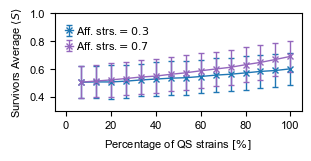

In [18]:
fig, axs = plt.subplots(1, figsize=(3, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, surv_a, marker='x', yerr=yy_err, capsize=2.5, markersize=4, linewidth=1, color='tab:blue', label=r'Aff. strs.$=0.3$')
p011=axs.errorbar(x_var, surv2_a, marker='x', yerr=yy2_err, capsize=2.5, markersize=4, linewidth=1, color='tab:purple', label=r'Aff. strs.$=0.7$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([0.3,1])
axs.set_xlim([-5,105])
axs.set_ylabel(r'Survivors Average $\langle S \rangle$', size=8)
axs.set_xlabel(r'Percentage of QS strains $[\%]$', size=8)
#axs.xaxis.set_label_coords(0.35, -0.3)

axs.legend(fontsize=8, labelspacing=0.2, frameon=False, handlelength=0.75, handletextpad=0.3)

plt.savefig(file+'/'+file2+'/fig3a.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 4b. Distributions with more dispersed data produce a higher averages of surviving strains.

In [ ]:
#Load distributions for S and D in the LV and LVQS simulations
#
file2='antifragility_8st_a-70'
file_c=np.load(file+'/survivors_'+file2+'.npy')
file_c=file_c[:,target_reseeds]/15

file2='antifragility_8mean_a-70-bin'
file_t0=np.load(file+'/survivors_'+file2+'.npy')
file_t0=file_t0[:,target_reseeds]/15

file2='antifragility_8mean_a-70-flat'
file_t2=np.load(file+'/survivors_'+file2+'.npy')
file_t2=file_t2[:,target_reseeds]/15

#Concatenate in the same column 
ppS=np.concatenate((file_c,file_t0))
ppS=np.concatenate((ppS,file_t2))

#Prepare a second column to label the otriginal data 
p1_l=np.full(len(file_c), 'Fixed value')
p0_l=np.full(len(file_t0), 'Binomial Dist')
p3_l=np.full(len(file_t2), 'Flat Dist')

ppS_l=np.concatenate((p1_l,p0_l))
ppS_l=np.concatenate((ppS_l,p3_l))

#Generate the data frames for each quantity S and D
df = pd.DataFrame({'Identifiers' : ppS_l, 'Values' : ppS})

#Export
df.to_csv(file+'/figs/fig_statistical_vis/figure7b_data.csv', index=False)

## Figure 6. Parameters that affect QS Impact.

### Panel 6a. Interaction strenght

In [68]:
target_reseeds = 200
trlnumber=5000

name=np.array(['51e10', '751e10', '1e9', '15e09', '31e9', '51e09', '1e08', '2e08', '5e08', '1e7', '15e07'])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    names[kk]='beta_'+name[kk]+'_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

variable='beta'
table=np.load(file+'/'+variable+'_var_'+str(0)+'.npy')
for num_file in range(len(name)-1):
    tab=np.load(file+'/'+variable+'_var_'+str(num_file+1)+'.npy')
    table=np.hstack((table,tab))
x_var=table[0,:]

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3]),
 array([ 9,  0,  1,  2,  3,  4,  5,  6,  5,  6,  7,  8,  0,  1,  2,  9, 10]))

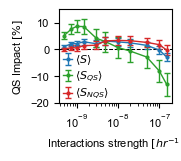

In [69]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, yy, marker='.', yerr=yy_err, capsize=2.5, markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
p011=axs.errorbar(x_var, yy1, marker='.', yerr=yy1_err, capsize=2.5, markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var, yy12, marker='.', yerr=yy12_err, capsize=2.5, markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_ylim([-20,15])
axs.set_xscale('log')

axs.legend(fontsize=8, loc=(0, -0.035), labelspacing=0.2, frameon=False, handlelength=0.75, handletextpad=0.3)

axs.set_xlabel(r'Interactions strength $[hr^{-1}]$', size=8)

plt.savefig(file+'/'+file2+'/figS2a.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 6b. Carrying Capacity

In [58]:
target_reseeds = 200
trlnumber=5000

name=np.array(['1e8', '51e8', '1e9', '51e9', '1e10', '51e10'])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    if kk!=2:
        names[kk]='beta_1e9_15s_st_'+name[kk]
    else:
        names[kk]='beta_1e9_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

variable='capacity'
table=np.load(file+'/'+variable+'_var_'+str(0)+'.npy')
for num_file in range(len(name)-1):
    tab=np.load(file+'/'+variable+'_var_'+str(num_file+1)+'.npy')
    table=np.hstack((table,tab))
x_var=table[0,:]

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

#When K is equal to QS activation threshold there is no QS dynamics and simulations are identical
yy[0], yy2[0], yy1[0], yy12[0] = 0, 0, 0, 0 

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


(array([1, 1, 1, 1, 1, 1, 3, 3]), array([0, 1, 2, 3, 4, 5, 1, 2]))

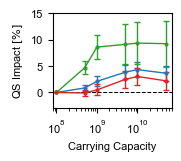

In [59]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, yy, marker='.', yerr=yy_err, capsize=2.5, markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
p011=axs.errorbar(x_var, yy1, marker='.', yerr=yy1_err, capsize=2.5, markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var, yy12, marker='.', yerr=yy12_err, capsize=2.5, markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-3,15])
axs.set_xlim([8*1e7, 7*1e10])
axs.set_xscale('log')
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_xlabel(r'Carrying Capacity', size=8)

plt.savefig(file+'/'+file2+'/figS2b.pdf', format="pdf", bbox_inches='tight', dpi=900)

plt.show()

### Panel 6c. Number of Strains.

In [60]:
target_reseeds = 200
trlnumber=5000

name=np.array(['5s', '10s', '15s', '20s'])
names=np.full(len(name), '',dtype=object)

num_strains = np.array([5,10,15,20])

for kk in range(len(name)):
    if kk!=2:
        names[kk]='beta_1e9_'+name[kk]+'_st_1e9'
    else:
        names[kk]='beta_1e9_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

variable='numst'
table=np.load(file+'/'+variable+'_var_'+str(0)+'.npy')
for num_file in range(len(name)-1):
    tab=np.load(file+'/'+variable+'_var_'+str(num_file+1)+'.npy')
    table=np.hstack((table,tab))
x_var=table[0,:]

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([1, 1, 1, 1, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 2]))

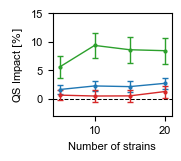

In [61]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, yy, marker='.', yerr=yy_err, capsize=2.5, markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
p011=axs.errorbar(x_var, yy1, marker='.', yerr=yy1_err, capsize=2.5, markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var, yy12, marker='.', yerr=yy12_err, capsize=2.5, markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-3,15])
axs.set_xlim([4,21])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_xlabel(r'Number of strains', size=8)

plt.savefig(file+'/'+file2+'/figS2c.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 6d. Growing Rate.

In [62]:
target_reseeds = 200
trlnumber=5000

name=np.array(['alph_1', 'alph_15', 'alph_2'])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    if kk!=2:
        names[kk]='beta_1e9_15s_st_1e9_'+name[kk]
    else:
        names[kk]='beta_1e9_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

variable='alpha'
table=np.load(file+'/'+variable+'_var_'+str(0)+'.npy')
for num_file in range(len(name)-1):
    tab=np.load(file+'/'+variable+'_var_'+str(num_file+1)+'.npy')
    table=np.hstack((table,tab))
x_var=table[0,:]

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([1, 1, 1, 3, 3]), array([0, 1, 2, 1, 2]))

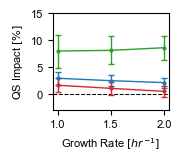

In [63]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, yy, marker='.', yerr=yy_err, capsize=2.5, markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
p011=axs.errorbar(x_var, yy1, marker='.', yerr=yy1_err, capsize=2.5, markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var, yy12, marker='.', yerr=yy12_err, capsize=2.5, markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-3,15])
#axs.set_xlim([4,21])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_xlabel(r'Growth Rate $[hr^{-1}]$', size=8)

plt.savefig(file+'/'+file2+'/figS2d.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 6e. QS activation threshold.

In [64]:
target_reseeds = 200
trlnumber=5000

name=np.array([1e5,5*1e5,1e6,5*1e6,1e7,5*1e7,1e8,5*1e8,1e9,5*1e9])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    names[kk]='beta_1e9_15s_st_1e9_N_QS_'+str(int(name[kk]))

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

variable='N_QS'
table=np.load(file+'/'+variable+'_var_'+str(0)+'.npy')
for num_file in range(len(name)-1):
    tab=np.load(file+'/'+variable+'_var_'+str(num_file+1)+'.npy')
    table=np.hstack((table,tab))
x_var=table[0,:]

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([0, 9, 0, 1, 2, 3, 4, 5, 6, 9, 0, 8, 9, 0, 1, 2, 3, 4, 5, 6, 9]))

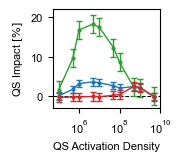

In [66]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)

p100=axs.errorbar(x_var, yy, marker='.', yerr=yy_err, capsize=2.5, markersize=4, linewidth=1, color='tab:blue', label=r'$\langle S \rangle$')
p011=axs.errorbar(x_var, yy1, marker='.', yerr=yy1_err, capsize=2.5, markersize=4, linewidth=1, color='tab:green', label=r'$\langle S_{QS} \rangle$')
p111=axs.errorbar(x_var, yy12, marker='.', yerr=yy12_err, capsize=2.5, markersize=4, linewidth=1, color='tab:red', label=r'$\langle S_{NQS} \rangle$')

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-3,22])
axs.set_xlim([5*1e4,1e10])
axs.set_xscale('log')
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_xlabel(r'QS Activation Density', size=8)

plt.savefig(file+'/'+file2+'/figS2e.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

## Figure 5. Different definitions of interactions after QS activation.

### Panel 5B. Only changes in incoming interactions are allowed.

In [9]:
target_reseeds = 200
trlnumber=5000

name=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    names[kk]='beta_'+str(name[kk])+'_1e9_15s_st_1e9'
    if kk==0:
        names[kk]='beta_1e9_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

x_var=np.array(['In-Out Neutral', 'Out-Neutral', 'In-Pos Out-Neg', 'G-O Agressive', 'G-IO Agressive', 'G-IO Cooperative',
                'In-Neutral', 'G-I Excluded', 'G-I Promoted','G-O Cooperative', 'G-IO Excluded', 'G-IO Promoted',
                'In-Neg Out-Pos', 'G-IO Positive', 'G-IO Negative'])

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3]),
 array([ 1,  3,  8, 11,  0,  1,  4,  6,  7, 10, 11, 12, 13, 14,  1,  3,  9,
         0,  1,  4,  6, 13]))

In [ ]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

colors=np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
colors2=np.array(['tab:cyan', 'bisque', 'yellowgreen', 'lightcoral'])

xx=np.array([r'$\langle S \rangle$', r'$\langle D \rangle$', r'$\langle S_{QS} \rangle$', r'$\langle S_{NQS} \rangle$'])

var1=6

x_var_aux=np.array([x_var[var1]])
yy_aux=np.array([yy[var1]])
yy2_aux=np.array([yy2[var1]])
yy1_aux=np.array([yy1[var1]])
yy12_aux=np.array([yy12[var1]])

yy_err_aux=np.array([yy_err[0][var1]])
yy2_err_aux=np.array([yy2_err[0][var1]])
yy1_err_aux=np.array([yy1_err[0][var1]])
yy12_err_aux=np.array([yy12_err[0][var1]])

i=0
    
GIO = np.array([yy_aux[i], yy2_aux[i], yy1_aux[i], yy12_aux[i]])
GIO_err = np.array([yy_err_aux[i], yy2_err_aux[i], yy1_err_aux[i], yy12_err_aux[i]])

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.errorbar(xx, GIO, marker='.', yerr=GIO_err, capsize=2.5, ecolor='black', linewidth=1, fmt='none')
axs.scatter(xx, GIO, c=colors, s=20)

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-5,10])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_title(x_var_aux[0], size=8)

#plt.savefig(file+'/'+file2+'/figS1B.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 5C. Only changes in outgoing interactions are allowed.

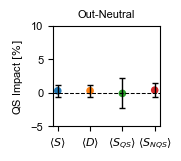

In [31]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

colors=np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
colors2=np.array(['tab:cyan', 'bisque', 'yellowgreen', 'lightcoral'])

xx=np.array([r'$\langle S \rangle$', r'$\langle D \rangle$', r'$\langle S_{QS} \rangle$', r'$\langle S_{NQS} \rangle$'])

var1=1

x_var_aux=np.array([x_var[var1]])
yy_aux=np.array([yy[var1]])
yy2_aux=np.array([yy2[var1]])
yy1_aux=np.array([yy1[var1]])
yy12_aux=np.array([yy12[var1]])

yy_err_aux=np.array([yy_err[0][var1]])
yy2_err_aux=np.array([yy2_err[0][var1]])
yy1_err_aux=np.array([yy1_err[0][var1]])
yy12_err_aux=np.array([yy12_err[0][var1]])

i=0
    
GIO = np.array([yy_aux[i], yy2_aux[i], yy1_aux[i], yy12_aux[i]])
GIO_err = np.array([yy_err_aux[i], yy2_err_aux[i], yy1_err_aux[i], yy12_err_aux[i]])

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.errorbar(xx, GIO, marker='.', yerr=GIO_err, capsize=2.5, ecolor='black', linewidth=1, fmt='none')
axs.scatter(xx, GIO, c=colors, s=20)

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-5,10])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_title(x_var_aux[0], size=8)

plt.savefig(file+'/'+file2+'/figS1C.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 5D. Usual QS model, incoming and outgoing itneractions taken from a gaussian distribution.

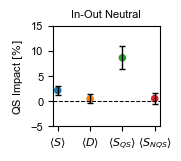

In [32]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

colors=np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
colors2=np.array(['tab:cyan', 'bisque', 'yellowgreen', 'lightcoral'])

xx=np.array([r'$\langle S \rangle$', r'$\langle D \rangle$', r'$\langle S_{QS} \rangle$', r'$\langle S_{NQS} \rangle$'])

var1=0

x_var_aux=np.array([x_var[var1]])
yy_aux=np.array([yy[var1]])
yy2_aux=np.array([yy2[var1]])
yy1_aux=np.array([yy1[var1]])
yy12_aux=np.array([yy12[var1]])

yy_err_aux=np.array([yy_err[0][var1]])
yy2_err_aux=np.array([yy2_err[0][var1]])
yy1_err_aux=np.array([yy1_err[0][var1]])
yy12_err_aux=np.array([yy12_err[0][var1]])

i=0
    
GIO = np.array([yy_aux[i], yy2_aux[i], yy1_aux[i], yy12_aux[i]])
GIO_err = np.array([yy_err_aux[i], yy2_err_aux[i], yy1_err_aux[i], yy12_err_aux[i]])

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.errorbar(xx, GIO, marker='.', yerr=GIO_err, capsize=2.5, ecolor='black', linewidth=1, fmt='none')
axs.scatter(xx, GIO, c=colors, s=20)

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-5,15])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_title(x_var_aux[0], size=8)

plt.savefig(file+'/'+file2+'/figS1D.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 5E. Changes in incoming interactions are always positive and outgoing interactions are always negative.

In [33]:
target_reseeds = 200
trlnumber=5000

name=np.array([3,13])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    names[kk]='beta_'+str(name[kk])+'_100_1e9_15s_st_1e9'

QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

x_var=np.array(['In-Out Neutral', 'Out-Neutral', 'In-Pos Out-Neg', 'G-O Agressive', 'G-IO Agressive', 'G-IO Cooperative',
                'In-Neutral', 'G-I Excluded', 'G-I Promoted','G-O Cooperative', 'G-IO Excluded', 'G-IO Promoted',
                'In-Neg Out-Pos', 'G-IO Positive', 'G-IO Negative'])

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([], dtype=int64), array([], dtype=int64))

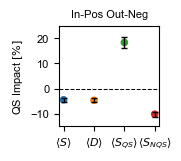

In [34]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

colors=np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
colors2=np.array(['tab:cyan', 'bisque', 'yellowgreen', 'lightcoral'])

xx=np.array([r'$\langle S \rangle$', r'$\langle D \rangle$', r'$\langle S_{QS} \rangle$', r'$\langle S_{NQS} \rangle$'])

var1=0

x_var_aux=np.array([x_var[2]])
yy_aux=np.array([yy[var1]])
yy2_aux=np.array([yy2[var1]])
yy1_aux=np.array([yy1[var1]])
yy12_aux=np.array([yy12[var1]])

yy_err_aux=np.array([yy_err[0][var1]])
yy2_err_aux=np.array([yy2_err[0][var1]])
yy1_err_aux=np.array([yy1_err[0][var1]])
yy12_err_aux=np.array([yy12_err[0][var1]])

i=0
    
GIO = np.array([yy_aux[i], yy2_aux[i], yy1_aux[i], yy12_aux[i]])
GIO_err = np.array([yy_err_aux[i], yy2_err_aux[i], yy1_err_aux[i], yy12_err_aux[i]])

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.errorbar(xx, GIO, marker='.', yerr=GIO_err, capsize=2.5, ecolor='black', linewidth=1, fmt='none')
axs.scatter(xx, GIO, c=colors, s=20)

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-15,25])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_title(x_var_aux[0], size=8)

plt.savefig(file+'/'+file2+'/figS1E.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 5F. Changes in incoming interactions are always negative and outgoing interactions are always positive.

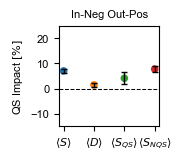

In [35]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

colors=np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
colors2=np.array(['tab:cyan', 'bisque', 'yellowgreen', 'lightcoral'])

xx=np.array([r'$\langle S \rangle$', r'$\langle D \rangle$', r'$\langle S_{QS} \rangle$', r'$\langle S_{NQS} \rangle$'])

var1=1

x_var_aux=np.array([x_var[12]])
yy_aux=np.array([yy[var1]])
yy2_aux=np.array([yy2[var1]])
yy1_aux=np.array([yy1[var1]])
yy12_aux=np.array([yy12[var1]])

yy_err_aux=np.array([yy_err[0][var1]])
yy2_err_aux=np.array([yy2_err[0][var1]])
yy1_err_aux=np.array([yy1_err[0][var1]])
yy12_err_aux=np.array([yy12_err[0][var1]])

i=0
    
GIO = np.array([yy_aux[i], yy2_aux[i], yy1_aux[i], yy12_aux[i]])
GIO_err = np.array([yy_err_aux[i], yy2_err_aux[i], yy1_err_aux[i], yy12_err_aux[i]])

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.errorbar(xx, GIO, marker='.', yerr=GIO_err, capsize=2.5, ecolor='black', linewidth=1, fmt='none')
axs.scatter(xx, GIO, c=colors, s=20)

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-15,25])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_title(x_var_aux[0], size=8)

plt.savefig(file+'/'+file2+'/figS1F.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

### Panel 5G. Changes in incoming interactions are always negative and outgoing interactions are always negative.


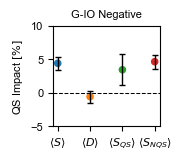

In [11]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

colors=np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
colors2=np.array(['tab:cyan', 'bisque', 'yellowgreen', 'lightcoral'])

xx=np.array([r'$\langle S \rangle$', r'$\langle D \rangle$', r'$\langle S_{QS} \rangle$', r'$\langle S_{NQS} \rangle$'])

var1=14

x_var_aux=np.array([x_var[var1]])
yy_aux=np.array([yy[var1]])
yy2_aux=np.array([yy2[var1]])
yy1_aux=np.array([yy1[var1]])
yy12_aux=np.array([yy12[var1]])

yy_err_aux=np.array([yy_err[0][var1]])
yy2_err_aux=np.array([yy2_err[0][var1]])
yy1_err_aux=np.array([yy1_err[0][var1]])
yy12_err_aux=np.array([yy12_err[0][var1]])

i=0
    
GIO = np.array([yy_aux[i], yy2_aux[i], yy1_aux[i], yy12_aux[i]])
GIO_err = np.array([yy_err_aux[i], yy2_err_aux[i], yy1_err_aux[i], yy12_err_aux[i]])

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.errorbar(xx, GIO, marker='.', yerr=GIO_err, capsize=2.5, ecolor='black', linewidth=1, fmt='none')
axs.scatter(xx, GIO, c=colors, s=20)

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-5,10])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_title(x_var_aux[0], size=8)

plt.savefig(file+'/'+file2+'/figS1G.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

## Panel 5H. Transitions to weak interactions.

In [12]:
def QSImpact(names, num_strains, target_reseeds, trlnumber):

    #Returns QS impact for each variable value. Reads data using the files' names.
    #num_strains is an array (each value for each file if necessary)

    number_points = len(names)
    
    QS_imp = np.zeros((4,number_points))  #QS Impact value for each value of the variable 
    p_val = np.zeros((4,number_points))   #p-values for each value fo the variable
    CI = np.zeros((4,number_points,2))    #Confidence intervals for each QS Impact avlue
    
    for kk in range(number_points):
        file_2=names[kk]
        fractions=np.load(file+'/fractions_weak_'+file_2+'.npy')
        fractions_IQS=np.load(file+'/fractionsNQS_'+file_2+'.npy')
        qs_s=np.load(file+'/qs_weak_'+file_2+'.npy')

        surv = survivors(fractions, num_strains[kk], target_reseeds, trlnumber)
        surv_IQS = survivors(fractions_IQS, num_strains[kk], target_reseeds, trlnumber)
        
        PD_QI, p_value, cb, cu = percentage_diff(surv_IQS, surv)

        QS_imp[0,kk] = PD_QI
        p_val[0,kk] = p_value
        CI[0,kk,0]=cb
        CI[0,kk,1]=cu

        shan = shannon(fractions, num_strains[kk], target_reseeds, trlnumber)
        shan_IQS = shannon(fractions_IQS, num_strains[kk], target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(shan_IQS, shan)

        QS_imp[1,kk] = PD_QI
        p_val[1,kk] = p_value
        CI[1,kk,0]=cb
        CI[1,kk,1]=cu

        QSsurv = QSsurvivors(fractions, num_strains[kk], qs_s, target_reseeds, trlnumber)
        QSsurv_IQS = QSsurvivors(fractions_IQS, num_strains[kk], qs_s, target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(QSsurv_IQS, QSsurv)

        QS_imp[2,kk] = PD_QI
        p_val[2,kk] = p_value
        CI[2,kk,0]=cb
        CI[2,kk,1]=cu

        NQSsurv = NQSsurvivors(fractions, num_strains[kk], qs_s, target_reseeds, trlnumber)
        NQSsurv_IQS = NQSsurvivors(fractions_IQS, num_strains[kk], qs_s, target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(NQSsurv_IQS, NQSsurv)

        QS_imp[3,kk] = PD_QI
        p_val[3,kk] = p_value
        CI[3,kk,0]=cb
        CI[3,kk,1]=cu
    
    return QS_imp, p_val, CI

In [13]:
target_reseeds = 200
trlnumber=5000

name=np.array([0])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    names[kk]='transitions'+str(name[kk])
QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

x_var=np.array(['To weak'])

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([], dtype=int64), array([], dtype=int64))

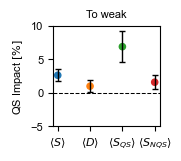

In [14]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

colors=np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
colors2=np.array(['tab:cyan', 'bisque', 'yellowgreen', 'lightcoral'])

xx=np.array([r'$\langle S \rangle$', r'$\langle D \rangle$', r'$\langle S_{QS} \rangle$', r'$\langle S_{NQS} \rangle$'])

var1=0

x_var_aux=np.array([x_var[var1]])
yy_aux=np.array([yy[var1]])
yy2_aux=np.array([yy2[var1]])
yy1_aux=np.array([yy1[var1]])
yy12_aux=np.array([yy12[var1]])

yy_err_aux=np.array([yy_err[0][var1]])
yy2_err_aux=np.array([yy2_err[0][var1]])
yy1_err_aux=np.array([yy1_err[0][var1]])
yy12_err_aux=np.array([yy12_err[0][var1]])

i=0
    
GIO = np.array([yy_aux[i], yy2_aux[i], yy1_aux[i], yy12_aux[i]])
GIO_err = np.array([yy_err_aux[i], yy2_err_aux[i], yy1_err_aux[i], yy12_err_aux[i]])

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.errorbar(xx, GIO, marker='.', yerr=GIO_err, capsize=2.5, ecolor='black', linewidth=1, fmt='none')
axs.scatter(xx, GIO, c=colors, s=20)

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-5,10])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_title(x_var_aux[0], size=8)

plt.savefig(file+'/'+file2+'/figS1H.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()

## Panel 5I. Transitions to strong interactions.

In [15]:
def QSImpact(names, num_strains, target_reseeds, trlnumber):

    #Returns QS impact for each variable value. Reads data using the files' names.
    #num_strains is an array (each value for each file if necessary)

    number_points = len(names)
    
    QS_imp = np.zeros((4,number_points))  #QS Impact value for each value of the variable 
    p_val = np.zeros((4,number_points))   #p-values for each value fo the variable
    CI = np.zeros((4,number_points,2))    #Confidence intervals for each QS Impact avlue
    
    for kk in range(number_points):
        file_2=names[kk]
        fractions=np.load(file+'/fractions_strong_'+file_2+'.npy')
        fractions_IQS=np.load(file+'/fractionsNQS_'+file_2+'.npy')
        qs_s=np.load(file+'/qs_strong_'+file_2+'.npy')

        surv = survivors(fractions, num_strains[kk], target_reseeds, trlnumber)
        surv_IQS = survivors(fractions_IQS, num_strains[kk], target_reseeds, trlnumber)
        
        PD_QI, p_value, cb, cu = percentage_diff(surv_IQS, surv)

        QS_imp[0,kk] = PD_QI
        p_val[0,kk] = p_value
        CI[0,kk,0]=cb
        CI[0,kk,1]=cu

        shan = shannon(fractions, num_strains[kk], target_reseeds, trlnumber)
        shan_IQS = shannon(fractions_IQS, num_strains[kk], target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(shan_IQS, shan)

        QS_imp[1,kk] = PD_QI
        p_val[1,kk] = p_value
        CI[1,kk,0]=cb
        CI[1,kk,1]=cu

        QSsurv = QSsurvivors(fractions, num_strains[kk], qs_s, target_reseeds, trlnumber)
        QSsurv_IQS = QSsurvivors(fractions_IQS, num_strains[kk], qs_s, target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(QSsurv_IQS, QSsurv)

        QS_imp[2,kk] = PD_QI
        p_val[2,kk] = p_value
        CI[2,kk,0]=cb
        CI[2,kk,1]=cu

        NQSsurv = NQSsurvivors(fractions, num_strains[kk], qs_s, target_reseeds, trlnumber)
        NQSsurv_IQS = NQSsurvivors(fractions_IQS, num_strains[kk], qs_s, target_reseeds, trlnumber)

        PD_QI, p_value, cb, cu = percentage_diff(NQSsurv_IQS, NQSsurv)

        QS_imp[3,kk] = PD_QI
        p_val[3,kk] = p_value
        CI[3,kk,0]=cb
        CI[3,kk,1]=cu
    
    return QS_imp, p_val, CI

In [16]:
target_reseeds = 200
trlnumber=5000

name=np.array([0])
names=np.full(len(name), '',dtype=object)

num_strains = np.full(len(name), 15)

for kk in range(len(name)):
    names[kk]='transitions'+str(name[kk])
QSIM, p_val, CI = QSImpact(names, num_strains, target_reseeds, trlnumber)

x_var=np.array(['To strong'])

yy = np.transpose(QSIM[0])
yy2 = np.transpose(QSIM[1])
yy1 = np.transpose(QSIM[2])
yy12 = np.transpose(QSIM[3])

yy_err = np.abs(np.vstack((yy,yy))-np.transpose(CI[0]))
yy2_err = np.abs(np.vstack((yy2,yy2))-np.transpose(CI[1]))
yy1_err = np.abs(np.vstack((yy1,yy1))-np.transpose(CI[2]))
yy12_err = np.abs(np.vstack((yy12,yy12))-np.transpose(CI[3]))

p_val_ind = np.asarray(p_val>0.05).nonzero()
p_val_ind

(array([0]), array([0]))

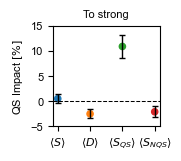

In [17]:
fig, axs = plt.subplots(1, figsize=(1.7, 1.5), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

colors=np.array(['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
colors2=np.array(['tab:cyan', 'bisque', 'yellowgreen', 'lightcoral'])

xx=np.array([r'$\langle S \rangle$', r'$\langle D \rangle$', r'$\langle S_{QS} \rangle$', r'$\langle S_{NQS} \rangle$'])

var1=0

x_var_aux=np.array([x_var[var1]])
yy_aux=np.array([yy[var1]])
yy2_aux=np.array([yy2[var1]])
yy1_aux=np.array([yy1[var1]])
yy12_aux=np.array([yy12[var1]])

yy_err_aux=np.array([yy_err[0][var1]])
yy2_err_aux=np.array([yy2_err[0][var1]])
yy1_err_aux=np.array([yy1_err[0][var1]])
yy12_err_aux=np.array([yy12_err[0][var1]])

i=0
    
GIO = np.array([yy_aux[i], yy2_aux[i], yy1_aux[i], yy12_aux[i]])
GIO_err = np.array([yy_err_aux[i], yy2_err_aux[i], yy1_err_aux[i], yy12_err_aux[i]])

axs.axhline(0, color='black', linestyle='--', linewidth=0.75)
axs.errorbar(xx, GIO, marker='.', yerr=GIO_err, capsize=2.5, ecolor='black', linewidth=1, fmt='none')
axs.scatter(xx, GIO, c=colors, s=20)

axs.tick_params(axis='both', which='both', labelsize=8)
axs.set_ylim([-5,15])
axs.set_ylabel(r'QS Impact $[\%]$', size=8)
axs.set_title(x_var_aux[0], size=8)

plt.savefig(file+'/'+file2+'/figS1I.pdf', format="pdf",bbox_inches='tight', dpi=900)

plt.show()